In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore') #action='once')
%matplotlib inline
features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign']
target = 'repaid'
df = pd.read_csv('./data/german.data', sep=' ',
                     names=features+[target])
numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'duration', 'persons', 'credits']

quantitative_features = list(filter(lambda x: x not in numerical_features, features))
X = pd.get_dummies(df, columns=quantitative_features, drop_first=False)
encoded_features = list(filter(lambda x: x != target, X.columns))

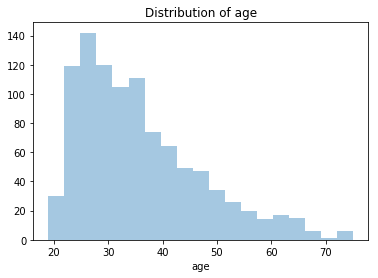

In [2]:
sns.distplot(df["age"], kde=False)
plt.title("Distribution of age")
plt.savefig("Images/age_distribution.png")

We split the data into three groups by age:

In [3]:
X.head()

,duration,amount,installment,residence time,age,credits,persons,repaid,checking account balance_A11,checking account balance_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,phone_A191,phone_A192,foreign_A201,foreign_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [4]:
df.head()

,checking account balance,duration,credit history,purpose,amount,savings,employment,installment,marital status,other debtors,...,property,age,other installments,housing,credits,job,persons,phone,foreign,repaid
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


We now look at how some of the variables are distributed in the different age segments.
First the employment variable:
```
Attribute 7:  (qualitative)
	      Present employment since
	      A71 : unemployed
	      A72 :       ... < 1 year
	      A73 : 1  <= ... < 4 years  
	      A74 : 4  <= ... < 7 years
	      A75 :       .. >= 7 years
```

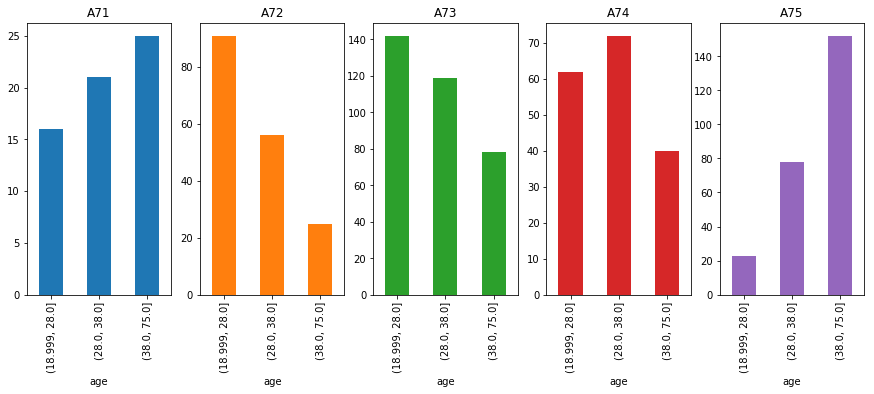

In [5]:
df.groupby(pd.qcut(df["age"], 3))\
    .employment.value_counts()\
    .sort_index()\
    .unstack()\
    .plot.bar(subplots=True,layout=(1,5),figsize=(15,5),legend=None)
plt.savefig("Images/age_employment_distribution.png")

We see that more old people are unemployed or have been in a job for a long time, whereas more young people recently started in their current job.

We now look at housing:
```
Attribute 15: (qualitative)
	      Housing
	      A151 : rent
	      A152 : own
	      A153 : for free
```

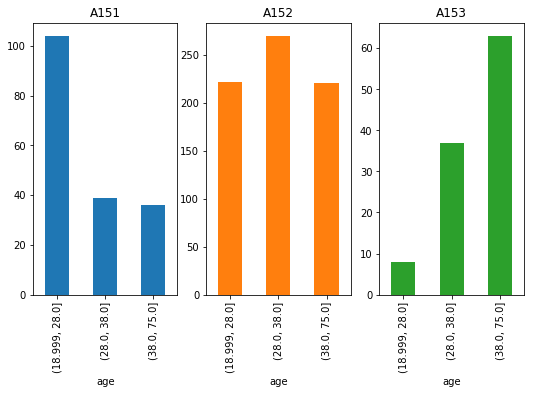

In [6]:
df.groupby(pd.qcut(df["age"], 3))\
    .housing.value_counts()\
    .sort_index()\
    .unstack()\
    .plot.bar(subplots=True,layout=(1,5),figsize=(15,5),legend=None)
plt.savefig("Images/age_housing_distribution.png")

There are clear differences between the groups on housing. Very few young people have free housing, and relatively few old and middle age people rent. This means we have a dependency between the age variable and the housing variable.

Finally, we look at whether there are differences between the groups in how often loans are paid back.

```
1 : Loan was repaid
2 : Loan was defaulted
```

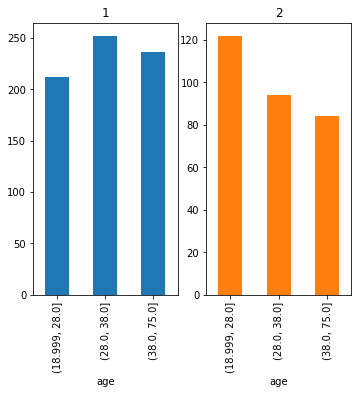

In [7]:
df.groupby(pd.qcut(df["age"], 3))\
    .repaid.value_counts()\
    .sort_index()\
    .unstack()\
    .plot.bar(subplots=True,layout=(1,5),figsize=(15,5),legend=None)
plt.savefig("Images/age_repaid_distribution.png")

As can be seen, a higher percentage of young people default on their loans

In conclusion; We expect there to be differences in the decision of whether to get a loan between the groups, and we need to estimate how much of that difference is due to age and how much is due to other factors.

In [8]:
import sys
sys.path.insert(0, './banker')
from forestbanker import RandomForestClassifierBanker
from randombanker import NeuralBankerGridSearch, RandomBanker
from kNNbanker import kNNbanker

Using TensorFlow backend.


In [9]:
from TestLendingFunctions import test_decision_maker
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
interest_rate = 0.005
decision_makers = []
decision_makers.append(RandomBanker(interest_rate))
decision_makers.append(kNNbanker(interest_rate))
decision_makers.append(RandomForestClassifierBanker(interest_rate))
decision_makers.append(NeuralBankerGridSearch(interest_rate))
### Do a number of preliminary tests by splitting the data in parts
from sklearn.model_selection import train_test_split
n_tests = 1
log = []
for decision_maker in decision_makers:
    print(type(decision_maker))
    utility = 0
    for iter in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X[encoded_features], X[target], test_size=0.2)
        #decision_maker.set_interest_rate(interest_rate)
        decision_maker.fit(X_train, y_train)
        utility += test_decision_maker(X_test, y_test, interest_rate, decision_maker)

    log.append("{}: {}".format(type(decision_maker), utility / n_tests))
    ypred = decision_maker.predict(X_test)
    ypred

    print("Accuracy score")
    print(accuracy_score(y_test, ypred))


    #Confusion matrix
    y_test_list = list(y_test)
    for i in range(0, len(y_test)):
        if y_test_list[i] == 2:
            y_test_list[i] = 0
    confusion = confusion_matrix(y_true=list(y_test_list), y_pred=list(ypred))
    print('Confusion matrix (p_threshold = 0.5):\n', confusion)
    labels = ['Class 0', 'Class 1']
    
    
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Metrics from classification matrix
    print('Classification accuracy:', (TP + TN) / float(TP + TN + FP + FN))  #should be the same as the accuracy score
    print('Classification error:', (FP + FN) / float(TP + TN + FP + FN))
    print('Sensitivity:', (TP / float(FN + TP)))
    print('Specificity:', (TN / (TN + FP)))
    print('False positive rate:', (FP / float(TN + FP)))
    print('Precision:', TP / float(TP + FP))
    print('Utility:', utility / n_tests)



<class 'randombanker.RandomBanker'>
Accuracy score
0.35
Confusion matrix (p_threshold = 0.5):
 [[32 31]
 [67 70]]
Classification accuracy: 0.51
Classification error: 0.49
Sensitivity: 0.5109489051094891
Specificity: 0.5079365079365079
False positive rate: 0.49206349206349204
Precision: 0.693069306930693
Utility: -112178.94161115379
<class 'kNNbanker.kNNbanker'>
Accuracy score
0.635
Confusion matrix (p_threshold = 0.5):
 [[ 16  51]
 [  6 127]]
Classification accuracy: 0.715
Classification error: 0.285
Sensitivity: 0.9548872180451128
Specificity: 0.23880597014925373
False positive rate: 0.7611940298507462
Precision: 0.7134831460674157
Utility: -11132.651101179677
<class 'forestbanker.RandomForestClassifierBanker'>
Accuracy score
0.645
Confusion matrix (p_threshold = 0.5):
 [[ 28  28]
 [ 15 129]]
Classification accuracy: 0.785
Classification error: 0.215
Sensitivity: 0.8958333333333334
Specificity: 0.5
False positive rate: 0.5
Precision: 0.821656050955414
Utility: 7313.839834168926
<class

In [10]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, "{0:.0f}%".format(100*c), ha='center', va='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

Text(0.5,1,'Actual outcomes')

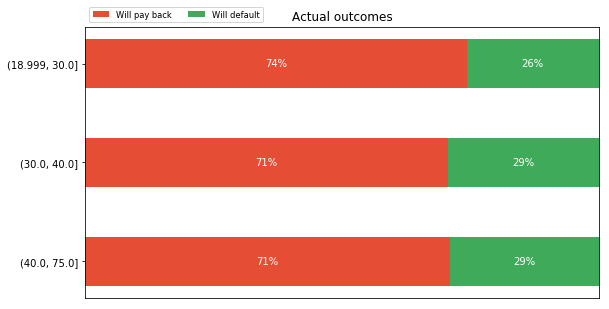

In [11]:
groups = X_test.groupby([pd.qcut(X_test["age"], 3)])
actual_actions = {}
category_names = ['Will pay back', 'Will default']
def get_percentages(actions):
    return [sum(actions)/len(actions), (len(actions)-sum(actions))/len(actions)]
results = {}
for key, group in groups:
    a = y_test[group.index]
    a[a == 2] = 0
    actual_actions[key] = a
    results[str(key)] = get_percentages(a)

survey(results, category_names)
plt.title("Actual outcomes")

RandomBanker
(18.999, 30.0]
[[10  8]
 [29 23]]
Calibration: Negative Action: 2.90	 Positive Action: 0.35
Balance: Negative Outcome: 0.80	 Positive Outcome: 1.26
(30.0, 40.0]
[[ 9 11]
 [21 27]]
Calibration: Negative Action: 2.33	 Positive Action: 0.41
Balance: Negative Outcome: 1.22	 Positive Outcome: 0.78
(40.0, 75.0]
[[ 8 10]
 [25 19]]
Calibration: Negative Action: 3.12	 Positive Action: 0.53
Balance: Negative Outcome: 1.25	 Positive Outcome: 1.32
kNNbanker
(18.999, 30.0]
[[10  8]
 [ 1 51]]
Calibration: Negative Action: 0.10	 Positive Action: 0.16
Balance: Negative Outcome: 0.80	 Positive Outcome: 0.02
(30.0, 40.0]
[[ 5 15]
 [ 2 46]]
Calibration: Negative Action: 0.40	 Positive Action: 0.33
Balance: Negative Outcome: 3.00	 Positive Outcome: 0.04
(40.0, 75.0]
[[ 3 15]
 [ 2 42]]
Calibration: Negative Action: 0.67	 Positive Action: 0.36
Balance: Negative Outcome: 5.00	 Positive Outcome: 0.05
RandomForestClassifierBanker
(18.999, 30.0]
[[17  1]
 [ 0 52]]
Calibration: Negative Action: 0.00

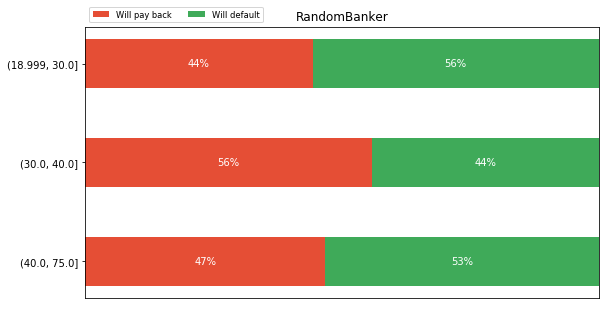

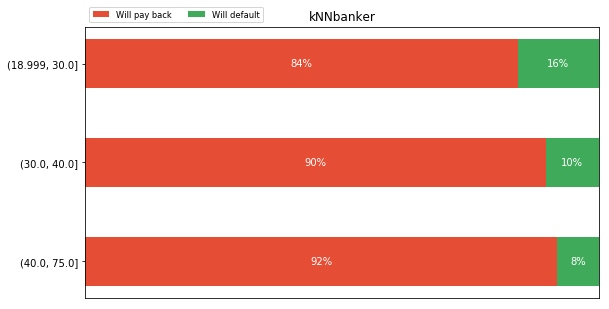

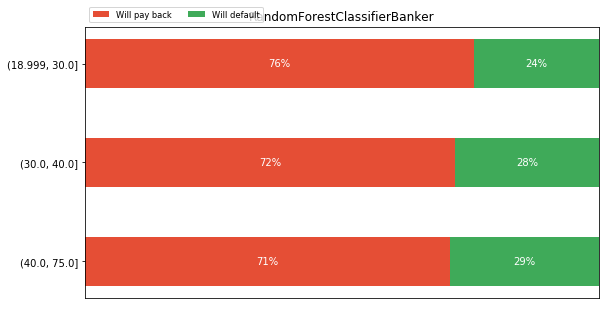

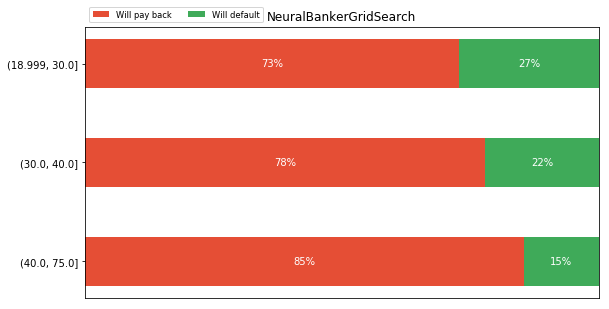

In [12]:
groups = X_test.groupby([pd.qcut(X_test["age"], 3)])

results = {}
for decision_maker in decision_makers:
    category_names = ['Will pay back', 'Will default']
    print(decision_maker.__class__.__name__)
    for key, group in groups:
        actions = decision_maker.predict(group)
        results[str(key)] = get_percentages(actions)
        # print confusion matrix to get P(y|a) for each category
        actual_actions = y_test[group.index]
        actual_actions[actual_actions == 2 ] = 0
        confusion = confusion_matrix(y_true=actual_actions, y_pred=actions)
        tn, fp, fn, tp = confusion.ravel()
        print(key)
        print(confusion)
        print("Calibration: Negative Action: {0:.2f}\t Positive Action: {1:.2f}".format(fn/tn, fp/tp))
        print("Balance: Negative Outcome: {0:.2f}\t Positive Outcome: {1:.2f}".format(fp/tn, fn/tp))
    survey(results, category_names)
    plt.title(decision_maker.__class__.__name__)
        

Calibration:

If the classifier is calibrated, then the ratio between entries in the columns of the confusion matrix, i.e the ratio of true negatives to false negatives and the ratio of false positives to true positives, should be the same across the agegroups.

Balance:

If the classifier is balanced, then the distribution of actions for any given outcome should be equal across classes. This maps to the ratios of the rows of the confusion matrix being equal for all agegroups.

TODO: run crossvalidation on these metrics.

What happens if we take amount into account?

Calibration:
>We should have P(y | a) = P(y | a, amount, age)

Balance:
>We should have P(a | y) = P(a | y, amount, age)



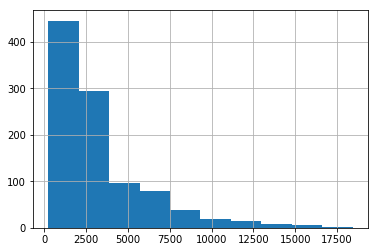

In [13]:
df["amount"].hist()

Text(0.5,1,'Actual outcomes')

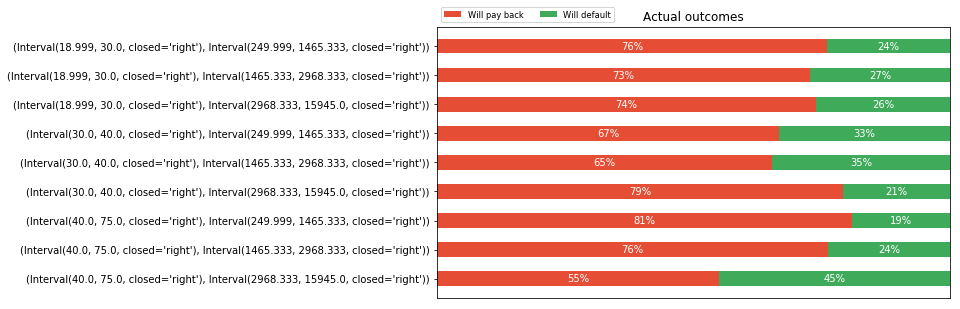

In [14]:
groups = X_test.groupby([pd.qcut(X_test["age"], 3), pd.qcut(X_test["amount"], 3)])
actual_actions = {}
category_names = ['Will pay back', 'Will default']
def get_percentages(actions):
    return [sum(actions)/len(actions), (len(actions)-sum(actions))/len(actions)]
results = {}
for key, group in groups:
    a = y_test[group.index]
    a[a == 2] = 0
    actual_actions[key] = a
    results[str(key)] = get_percentages(a)

survey(results, category_names)
plt.title("Actual outcomes")

RandomBanker
(Interval(18.999, 30.0, closed='right'), Interval(249.999, 1465.333, closed='right'))
[[ 2  4]
 [10  9]]
Calibration: Negative Action: 5.00	 Positive Action: 0.44
Balance: Negative Outcome: 2.00	 Positive Outcome: 1.11
(Interval(18.999, 30.0, closed='right'), Interval(1465.333, 2968.333, closed='right'))
[[ 3  3]
 [ 5 11]]
Calibration: Negative Action: 1.67	 Positive Action: 0.27
Balance: Negative Outcome: 1.00	 Positive Outcome: 0.45
(Interval(18.999, 30.0, closed='right'), Interval(2968.333, 15945.0, closed='right'))
[[1 5]
 [8 9]]
Calibration: Negative Action: 8.00	 Positive Action: 0.56
Balance: Negative Outcome: 5.00	 Positive Outcome: 0.89
(Interval(30.0, 40.0, closed='right'), Interval(249.999, 1465.333, closed='right'))
[[3 4]
 [7 7]]
Calibration: Negative Action: 2.33	 Positive Action: 0.57
Balance: Negative Outcome: 1.33	 Positive Outcome: 1.00
(Interval(30.0, 40.0, closed='right'), Interval(1465.333, 2968.333, closed='right'))
[[4 4]
 [7 8]]
Calibration: Negativ

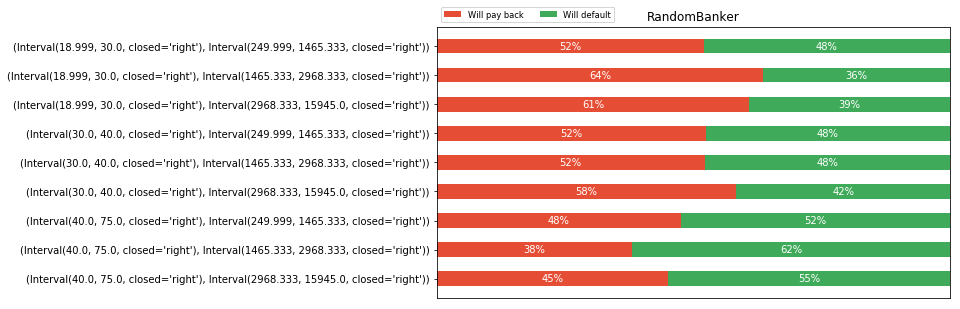

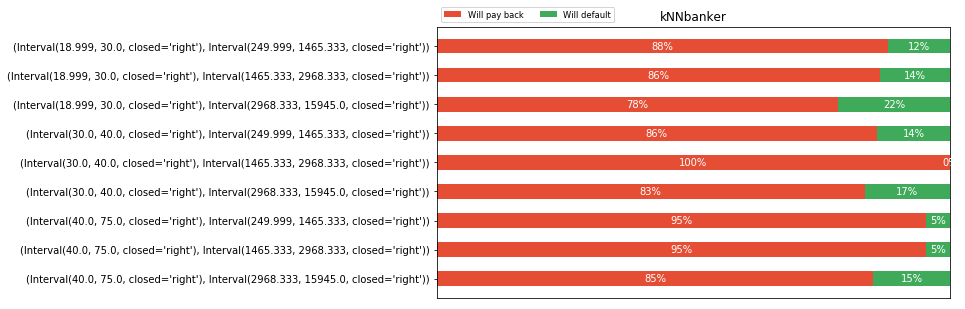

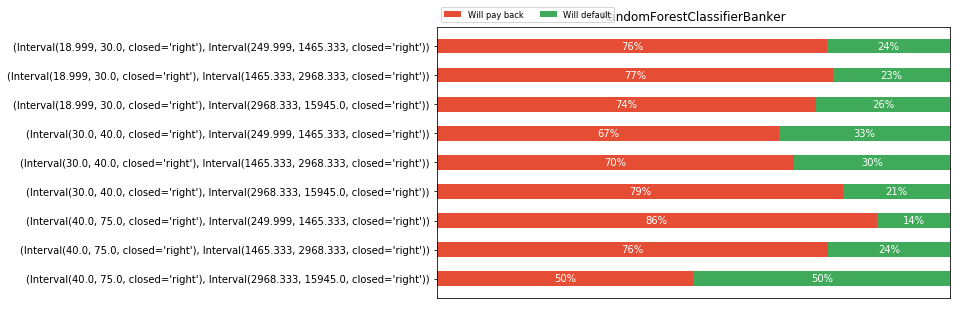

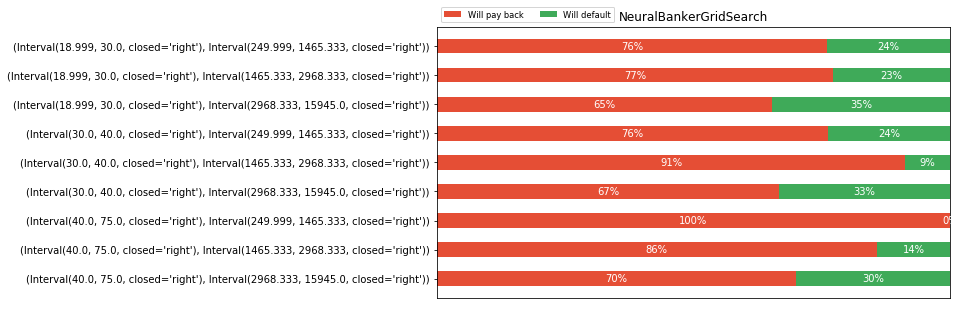

In [15]:
results = {}
for decision_maker in decision_makers:
    category_names = ['Will pay back', 'Will default']
    print(decision_maker.__class__.__name__)
    for key, group in groups:
        actions = decision_maker.predict(group)
        results[str(key)] = get_percentages(actions)
        # print confusion matrix to get P(y|a) for each category
        actual_actions = y_test[group.index]
        actual_actions[actual_actions == 2 ] = 0
        confusion = confusion_matrix(y_true=actual_actions, y_pred=actions)
        tn, fp, fn, tp = confusion.ravel()
        print(key)
        print(confusion)
        print("Calibration: Negative Action: {0:.2f}\t Positive Action: {1:.2f}".format(fn/tn, fp/tp))
        print("Balance: Negative Outcome: {0:.2f}\t Positive Outcome: {1:.2f}".format(fp/tn, fn/tp))
    survey(results, category_names)
    plt.title(decision_maker.__class__.__name__)
        

One problem with including amount is that each group becomes very small, and thus we are less sure about whether the difference between them is due to random fluctuations or due to a bias in the classifier.

(reference the importance plot) Amount is the most informative variable, and so attempting to gain fairness with respect to this variable might have a large impact on the quality of our decisions.

The utility fairness trade-off can be modelled like this:

\begin{align}
 V(\lambda, \theta, \pi) &= (1-\lambda)*U(\theta, \pi)-\lambda F(\theta,\pi)
\end{align}

Where $\lambda$ governs how important fairness is. $\theta$ is the parameters of the classifier and $\pi$ is the classifier.
$U(\cdot)$ is a function measuring the utility of the decision function and $F(\cdot)$ is a function measuring the fairness of the decision function.

TODO: Decide on fairness function

Calibration:
\begin{align}
F_{calibration}(\theta, \pi) = \sum_{y, a, z}{[P^{\pi}_{\theta}(y \mid a, z) - P^{\pi}_{\theta}(y \mid a)]^{2}}
\end{align}

Balance:
\begin{align}
F_{balance}(\theta, \pi) &= \sum_{y, z, a}{[P^{\pi}_{\theta}(a \mid y , z)-P^{\pi}_{\theta}(a \mid y)]^{2}}
\end{align}

In [29]:
def FCalibration(classifier, X, y):
    # Calculate action selection a
    utility = 0
    actions = decision_maker.get_best_action(X)
    sum = 0
    # For each action a
    X = X.assign(a=actions)
    X = X.assign(y=y)
    agroups = X.groupby(X["a"])
    # For each agegroup z
    azgroups = X.groupby(["a", pd.qcut(X["age"], 3)])
    for key, group in azgroups:
        # For each actual outcome y
        for outcome in [1, 2]:
            #sum += P(y | a, z) - P(y | a)
            sum += ((group[group["y"] == outcome].size / group.size) - (X[(X["a"] == key[0]) & (X["y"] == outcome)].size/X[X["a"] == key[0]].size))**2
    return sum

def FBalance(classifier, X, y):
    # Calculate action selection a
    utility = 0
    actions = decision_maker.get_best_action(X)
    sum = 0
    # For each action a
    X = X.assign(a=actions)
    X = X.assign(y=y)
    agroups = X.groupby(X["y"])
    # For each agegroup z
    azgroups = X.groupby(["y", pd.qcut(X["age"], 3)])
    for key, group in azgroups:
        # For each actual outcome y
        for outcome in [1, 2]:
            #sum += P(y | a, z) - P(y | a)
            sum += ((group[group["a"] == outcome].size / group.size) - (X[(X["y"] == key[0]) & (X["a"] == outcome)].size/X[X["y"] == key[0]].size))**2
    return sum

for decision_maker in decision_makers:
    print(decision_maker.__class__.__name__)
    print("Calibration: " + str(FCalibration(decision_maker, X_test, y_test)))
    print("Balance: " + str(FBalance(decision_maker, X_test, y_test)))

RandomBanker
Calibration: 0.0016566252184904086
Balance: 0.0
kNNbanker
Calibration: 0.016637003650739706
Balance: 0.0310461732546939
RandomForestClassifierBanker
Calibration: 0.009728002749432155
Balance: 0.01862191203318826
NeuralBankerGridSearch
Calibration: 0.004066434613049543
Balance: 0.014646957063915115



## Balancing fairness and utility

We now want to find a policy $\pi(x)$ which is optimised for both fairness and utility.
It is possible to do this using stochastic gradient descent(SGD). SGD requires calculating the gradient of $V(x)$, and that the gradient contains useful information.

\begin{align}
\nabla_{\pi} V(\pi, \theta) &= \nabla_{\pi} (1-\lambda) U(\theta, \pi) + \nabla_{\pi} \lambda F(\theta, \pi) \\
\end{align}

At least for some of our classifiers, for instance the neural network, we allready have the gradient of $U(\theta, \pi)$ with respect to $\pi$.

We therefore focus on the gradient $\nabla_{\pi} F(\theta, \pi)$. $\pi$ is our rule for making decisions $a$ based on observations $x$. That gives us the following:

\begin{align}
\nabla_{\pi} F(\pi, \theta) &= \nabla_{\pi}\sum_{y, a, z}{[P^{\pi}_{\theta}(y \mid a, z) - P^{\pi}_{\theta}(y \mid a)]^{2}} \\
&= 2*\nabla_{\pi}\sum_{y, a, z}{[P_{\theta}(y \mid \pi(x), z) - P_{\theta}(y \mid \pi(x))]} \\
&= 2*\sum_{y, a, z}{[\nabla_{\pi}P_{\theta}(y \mid \pi(x), z) - \nabla_{\pi}P_{\theta}(y \mid \pi(x))]} \\
\end{align}

Let's now assume $\pi$ has the tunable parameters $\omega$.

\begin{align}\nabla_{\pi}
\nabla_{\pi} F(\pi, \theta) &= \nabla_{\omega}\sum_{y, a, z}{[P_{\theta}(y \mid \pi(x, \omega), z) - P_{\theta}(y \mid \pi(x, \omega))]^{2}} \\
\end{align}



Our decision rule $\pi$ is "Give the loan if the expected return is more than 0, and reject it otherwise". This means that it is basically a step-function which is either 1 or 0 for all $x$. Consequently the derivative of $V(x)$ is zero everywhere.

In [30]:
def FCalibrationAmount(classifier, X, y):
    # Calculate action selection a
    utility = 0
    actions = decision_maker.get_best_action(X)
    sum = 0
    # For each action a
    X = X.assign(a=actions)
    X = X.assign(y=y)
    agroups = X.groupby(X["a"])
    # For each agegroup z
    azgroups = X.groupby(["a", pd.qcut(X["age"], 3), pd.qcut(X["amount"], 3)])
    for key, group in azgroups:
        # For each actual outcome y
        for outcome in [1, 2]:
            #sum += P(y | a, z) - P(y | a)
            sum += ((group[group["y"] == outcome].size / group.size) - (X[(X["a"] == key[0]) & (X["y"] == outcome)].size/X[X["a"] == key[0]].size))**2
    return sum

def FBalanceAmount(classifier, X, y):
    # Calculate action selection a
    utility = 0
    actions = decision_maker.get_best_action(X)
    sum = 0
    # For each action a
    X = X.assign(a=actions)
    X = X.assign(y=y)
    agroups = X.groupby(X["y"])
    # For each agegroup z
    azgroups = X.groupby(["y", pd.qcut(X["age"], 3), pd.qcut(X["amount"], 3)])
    for key, group in azgroups:
        # For each actual outcome y
        for outcome in [1, 2]:
            #sum += P(y | a, z) - P(y | a)
            sum += ((group[group["a"] == outcome].size / group.size) - (X[(X["y"] == key[0]) & (X["a"] == outcome)].size/X[X["y"] == key[0]].size))**2
    return sum

for decision_maker in decision_makers:
    print(decision_maker.__class__.__name__)
    print("Calibration: " + str(FCalibrationAmount(decision_maker, X_test, y_test)))
    print("Balance: " + str(FBalanceAmount(decision_maker, X_test, y_test)))

RandomBanker
Calibration: 0.10654064253258884
Balance: 0.0
kNNbanker
Calibration: 0.42487543149820256
Balance: 0.287147580000106
RandomForestClassifierBanker
Calibration: 0.14787351515643027
Balance: 0.16560703172230892
NeuralBankerGridSearch
Calibration: 0.1576220995623674
Balance: 0.19304758910373615


\begin{align}
P(y \mid a, z) &= P(y \mid a)
\end{align}